# Plot Translation from Acceleration to Rotation as Density Plots

## Imports

In [1]:
from obspy import * 
from pandas import *
from os import listdir

import os
import netCDF4 as nc
import numpy as np
import pickle
import matplotlib.pyplot as plt

from andbro__savefig import __savefig

import warnings
warnings.filterwarnings('ignore')

In [2]:
if os.uname().nodename == "lighthouse":
    root_path = "/home/andbro/"
    data_path = "/home/andbro/kilauea-data/"
    archive_path = "/home/andbro/freenas/"
elif os.uname().nodename == "kilauea":
    root_path = "/home/brotzer/"
    data_path = "/export/data/"
    archive_path = "/import/freenas-ffb-01-data/"

## Configurations

In [3]:
config = {}

config['workdir'] = f"{data_path}LNM/data/"

config['datapath'] = config['workdir']+"FINAL/"

# config['love_phase_nc'] = "PHASE_VELOCITY_MODEL/LovePhaseVelocity.nc"
# config['rayleigh_phase_nc'] = "PHASE_VELOCITY_MODEL/RayleighPhaseVelocity.nc"

# config['year'] = "2019"''
# config['datadir_spectra'] = config['workdir']+config['year']+"/"

# config['noise_models'] =  config['workdir']+"MODELS/"+"noise_models.npz"

# config['spectra_files'] = listdir(config['datadir_spectra'])

# config['outdir'] = config['workdir']+"STATS/"

config['period_lower'] = 2.5
config['period_upper'] = 200

config['outpath_figures'] = "/import/kilauea-data/LNM/figures_final/"

config['excluded_stations'] = ['KAPI', 'TRQA', 'QSPA', 'FUNA', 'SAML', 'PAYG', 'SDV', 'TSUM']


In [4]:
def __read_vphase(path_to_file):
    
    df0 = read_pickle(path_to_file)

    pp0 = df0['period']
    
    df0.drop(columns=['period'], inplace=True)
    
    return pp0, df0.to_numpy().transpose()

## Load Datasets

In [5]:
petersen = read_pickle(config['datapath']+"petersen_nlnm_nhnm.pkl")

In [6]:
with open(config['workdir']+"MODELS/"+"RLNM_distribution.pkl",'rb') as f:
    rlnm_dist = pickle.load(f)

In [7]:
sta_med = read_pickle(config['datapath']+"station_2019_stations_median.pkl")

In [8]:
velocities_land_love = read_pickle(config['datapath']+'LOVE_vphase_land_only.pkl')
velocities_land_rayleigh = read_pickle(config['datapath']+'RAYLEIGH_vphase_land_only.pkl')


# vphase_land_love  = __read_vphase(config['datapath']+"vphase_land_love.pkl")
# vphase_ocean_love = __read_vphase(config['datapath']+"vphase_ocean_love.pkl")

pp_land_rayleigh, vphase_land_rayleigh  = __read_vphase(config['datapath']+"vphase_land_rayleigh.pkl")
vphase_ocean_rayleigh = __read_vphase(config['datapath']+"vphase_ocean_rayleigh.pkl")

## Processing

In [9]:
sta_med_psds = np.array([sta_med[sta] for sta in sta_med.keys() if sta is not 'period' and sta.split(".")[0] not in config['excluded_stations']])

sta_med_pp = sta_med['period']

In [10]:
def __calculate_density(psd_array, bins=20, density=False, axis=1):

    from numpy import argmax, std, median, isnan, array, histogram, nan
    from scipy.stats import median_abs_deviation as mad
    
    ## exclude psds with only NaN values
    psds = array([psd for psd in psd_array if not isnan(psd).all()])
    print(f"total spectra used: {psd_array.shape[0]}")

    
    ## find overall minimum and maxium values
    max_value = max([max(sublist) for sublist in psd_array])
    min_value = min([min(sublist) for sublist in psd_array])

    
    ## define empty lists
    dist, dist_maximas, bins_maximas, bins_medians, stds, mads = [], [], [], [], [], []
    
    count = 0
    for h in range(len(psd_array[axis])):
        
        psd = psd_array[:,h]
        
        ## compute histograms
        hist, bin_edges = histogram(psd, bins=bins, range=(min_value, max_value), density=density);
                
        ## center bins
        bin_mids = 0.5*(bin_edges[1:] + bin_edges[:-1])
        
        ## normalization
#         if  True:
#             hist = [val / len(psd_array[:,h]) for val in hist]
#             config['set_density'] = True

        ## check if density works
        DX = abs(max_value-min_value)/bins
        SUM = sum(hist)
        if str(round(SUM*DX,1)) != "1.0":
            print(round(SUM*DX,1))
            count+=1
        
        ## modify histogram with range increment
        hist = hist*DX
        
        ## append values to list
        dist.append(hist)
        stds.append(std(hist))
        dist_maximas.append(max(hist))
        bins_maximas.append(bin_mids[argmax(hist)])
        mads.append(mad(hist)) 
        
        
        
        ## compute median
        psd = psd[~(isnan(psd))]
        bins_medians.append(median(psd[psd != 0]))
    
    
    ## prepare output   
    output = {}
    output['dist'] = array(dist)
    output['bin_mids'] = array(bin_mids)
    output['bins_maximas'] = array(bins_maximas)
    output['stds'] = array(stds)
    output['mads'] = array(mads)
    output['bins_medians'] = array(bins_medians)
    output['set_density'] = density
    output['total'] = psd_array.shape[0]
    
    if count > 0:
        print(f" {count} errors found for density computation!!!")
    
    return output

In [11]:
def __calculate_density_log(psd_array, bins=20, density=False, axis=1):

    from numpy import argmax, std, median, isnan, array, histogram, nan
    from scipy.stats import median_abs_deviation as mad
    
    def __convert_to_log(in_psds):

        out_psds = np.zeros(in_psds.shape)
        rows_with_zeros = 0
        for i, psd in enumerate(in_psds):
            if np.count_nonzero(psd) != len(psd):
                rows_with_zeros +=1
                psd = [nan for val in psd if val == 0]
            out_psds[i,:] = np.log10(psd)
            if np.isinf(out_psds[i,:]).any():
                out_psds[i,:] = nan * ones(len(out_psds[i,:]))

        return out_psds

    ## converting to log10
    psd_array = __convert_to_log(psd_array)   
    
    ## exclude psds with only NaN values
    psds = array([psd for psd in psd_array if not isnan(psd).all()])
    print(f"total spectra used: {psd_array.shape[0]}")
    
    ## find overall minimum and maxium values
    max_value = max([max(sublist) for sublist in psd_array])
    min_value = min([min(sublist) for sublist in psd_array])
#     print(min_value, max_value)

    ## define empty lists
    dist, dist_maximas, bins_maximas, bins_medians, stds, mads = [], [], [], [], [], []
    
    count = 0
    for h in range(len(psd_array[axis])):
        
        psd = psd_array[:,h]
        
        ## compute histograms
        hist, bin_edges = histogram(psd, bins=bins, range=(min_value, max_value), density=density);
                
        ## center bins
        bin_mids = 0.5*(bin_edges[1:] + bin_edges[:-1])
        
        ## normalization
#         if True:
#             hist = [val / len(psd_array[:,h]) for val in hist]
#             config['set_density'] = True

        ## check if density works
        DX = abs(max_value-min_value)/bins
        SUM = sum(hist)
        if str(SUM*DX) != "1.0":
            count+=1
        
        ## modify histogram with range increment
        hist = hist*DX
        
        ## append values to list
        dist.append(hist)
        stds.append(std(hist))
        dist_maximas.append(max(hist))
        bins_maximas.append(bin_mids[argmax(hist)])
        mads.append(mad(hist)) 
        
        ## compute median
        psd = psd[~(isnan(psd))]
        bins_medians.append(median(psd[psd != 0]))

    ## undo log conversion    
    output = {}
    output['dist'] = array(dist)
    output['bin_mids'] = 10**array(bin_mids)
    output['bins_maximas'] = 10**array(bins_maximas)
    output['stds'] = 10**array(stds)
    output['mads'] = 10**array(mads)
    output['bins_medians'] = 10**array(bins_medians)
    output['set_density'] = density
    output['total'] = psd_array.shape[0]
    
    if count > 0:
        print(f" {count} errors found for density computation!!!")
    
    return output

In [12]:
sta_med_ppsd = __calculate_density_log(sta_med_psds, bins=80, density=True)

vel_rayleigh_ppsd = __calculate_density(vphase_land_rayleigh, bins=100, density=True)
# vel_love_ppsd = __calculate_density(vphase_land_love, bins=100, density=True)

total spectra used: 120
total spectra used: 1542


## Plotting

In [30]:
def __makeplot_PPSD_all(config, pp1, data1, pp2, data2, vmed, data3):

    from matplotlib import colors, ticker
    from numpy import ones, convolve, array, log10, roll, sqrt

    bins1, bins_medians1, bins_maximas1, dist1 = data1['bin_mids'], data1['bins_medians'], data1['bins_maximas'], data1['dist']
    bins2, bins_medians2, bins_maximas2, dist2 = data2['bin_mids'], data2['bins_medians'], data2['bins_maximas'], data2['dist']
    bins3, bins_medians3, bins_maximas3, dist3 = data3['bin_mids'], data3['bins_medians'], data3['bins_maximas'], data3['dist']
    
    bins3 = 10**(bins3/10)
    pp3 = data3['period']
    
    def add_colorbar(mappable, padding):
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        last_axes = plt.gca()
        ax = mappable.axes
        fig = ax.figure
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = fig.colorbar(mappable, cax=cax)
        cbar.set_label("Propability Density", fontsize=font, labelpad=padding, color="white")
        cbar.ax.xaxis.set_major_formatter(ticker.ScalarFormatter())        
        plt.sca(last_axes)
        return cbar

    NN = 3
    
    ## plotting
    fig, ax = plt.subplots(NN,1,figsize=(10,15), sharex=True)
    
    plt.subplots_adjust(hspace=0.05)

    font=14

    cmap = plt.cm.get_cmap('magma_r')
#     cmap = plt.cm.get_cmap('viridis')
    cmap.set_under(color='white')

    im0 = ax[0].pcolor(pp1, bins1, dist1.T, 
                       cmap=cmap,
                       vmin=1e-12, 
                       alpha=0.99,
                       zorder=1,
                      )
    
    im1 = ax[1].pcolor(pp2, bins2, dist2.T, 
                       cmap=cmap,
                       vmin=1e-12, 
                       alpha=0.99,
                       zorder=1,
                       )

    im2 = ax[2].pcolor(pp3, bins3, dist3.T, 
                         cmap=cmap,
                         vmin=1e-12, 
                         alpha=0.99,
                         zorder=1,
                         )


    ## add Frequency Axis
    g = lambda x: 1/x
    ax2 = ax[0].secondary_xaxis("top", functions=(g,g))
    ax2.set_xlabel("Frequency (Hz)", fontsize=font, labelpad=-5)
    ax2.set_xticklabels(1/pp1, fontsize=11)    
    ax2.tick_params(axis='both', labelsize=font-2)

    ## plot medians
    ax[0].plot(pp1, bins_medians1, color='black', alpha=0.8, label="median", zorder=2)
#     ax[1].plot(vmed['periods_mod'], vmed['vphase_median'], 'k', label="median", zorder=2)
    ax[1].plot(vmed['periods_mod'], vmed['vphase_max'], 'k', label="maxima", zorder=2)
    ax[2].plot(data3['period'], 10**(data3['bins_minimum']/10), color="black", zorder=2, lw=1.5, alpha=0.8, label="RLNM")
    
    ## add NLNM
    ax[0].plot(petersen['periods'], 10**(petersen['nlnm']/10), color='black', alpha=0.8, ls="--")
    ax[0].plot(petersen['periods'], 10**(petersen['nhnm']/10), color='black', alpha=0.8, ls="--")
    

    ## modify axes
    ax[0].set_xscale('log')
    ax[0].set_xlim(config['period_lower'], config['period_upper'])
    ax[0].set_yscale('log')
    ax[0].set_ylim(1e-20, 5e-9)
        
    ax[1].set_ylim(0.6, 5.3)
    
    ax[2].set_xscale('log')
    ax[2].set_xlim(config['period_lower'], config['period_upper'])
    ax[2].set_yscale('log')
    ax[2].set_ylim(8e-27, 1e-20)

    
    ## add panel labels
    ax[0].text(.01, .99, 'a)', ha='left', va='top', transform=ax[0].transAxes, fontsize=font+2)
    ax[1].text(.01, .99, 'b)', ha='left', va='top', transform=ax[1].transAxes, fontsize=font+2)
    ax[2].text(.01, .99, 'c)', ha='left', va='top', transform=ax[2].transAxes, fontsize=font+2)

    ax[0].text(.90, .045, 'N = 120' , ha='left', va='top', transform=ax[0].transAxes, fontsize=font-3)
    ax[1].text(.89, .045, 'N = 1542', ha='left', va='top', transform=ax[1].transAxes, fontsize=font-3)

    ax[0].text(40, 5e-14, "NHNM", fontsize=font, rotation=5)
    ax[0].text(6, 2e-17, "NLNM", fontsize=font, rotation=-30)
    
    ## add colorbar
#     cax1 = fig.add_axes()
#     cb1 = plt.colorbar(im0, cax=cax1, alpha=1.0)
#     cb1.set_label("Propability Density", fontsize=font)
 
    add_colorbar(im0, -40)
    add_colorbar(im1, -40)
    add_colorbar(im2, -40)
    
    ## add labels
    ax[0].set_ylabel(r"PPSD (m$^2$/s$^4$/$Hz$)", fontsize=font)
    ax[1].set_ylabel(r"Rayleigh Phase Velocity (km/s)", fontsize=font, labelpad=5)
    ax[2].set_ylabel(r"PPSD (rad$^2$/s$^2$/$Hz$)",fontsize=font)
    ax[NN-1].set_xlabel("Period (s)", fontsize=font, labelpad=-5)

    ## add other stuff
    for nn in range(NN):
        ax[nn].grid(axis="both", which="both", ls="--", zorder=3, alpha=0.4)
        ax[nn].legend(loc=1)
        ax[nn].tick_params(axis='both', labelsize=font-2)

        
    plt.show();
    return fig

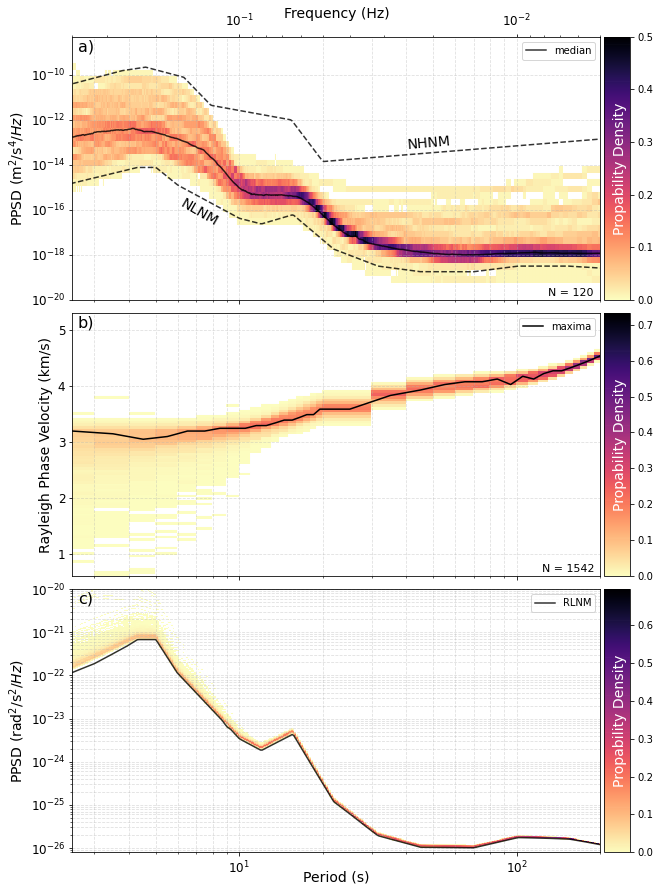

In [31]:
fig = __makeplot_PPSD_all(config,
                          sta_med_pp, sta_med_ppsd, 
                          pp_land_rayleigh, vel_rayleigh_ppsd,
                          velocities_land_rayleigh,
                          rlnm_dist,
                          )

In [32]:
__savefig(fig, outpath=config['outpath_figures'], outname="joint_PPSD", mode="png", dpi=300)


   -> saving /import/kilauea-data/LNM/figures_final/joint_PPSD.png ...

   -> Done



## Plotting Colorlines

In [27]:
def __makeplot_colorlines_all(config, pp1, data1, pp2, data2, vmed, data3):

    from matplotlib import colors, ticker
    from numpy import ones, convolve, array, log10, roll, sqrt, shape

#     bins1, bins_medians1, bins_maximas1, dist1 = data1['bin_mids'], data1['bins_medians'], data1['bins_maximas'], data1['dist']
    bins2, bins_medians2, bins_maximas2, dist2 = data2['bin_mids'], data2['bins_medians'], data2['bins_maximas'], data2['dist']
    bins3, bins_medians3, bins_maximas3, dist3 = data3['bin_mids'], data3['bins_medians'], data3['bins_maximas'], data3['dist']

    
    bins3 = 10**(bins3/10)
    pp3 = data3['period']
    
    def add_colorbar(mappable, padding):
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        last_axes = plt.gca()
        ax = mappable.axes
        fig = ax.figure
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = fig.colorbar(mappable, cax=cax)
        cbar.set_label("Propability Density", fontsize=font, labelpad=padding, color="white")
        cbar.ax.xaxis.set_major_formatter(ticker.ScalarFormatter())        
        plt.sca(last_axes)
        return cbar

    NN = 3
    font=14
    
    cmap = plt.cm.get_cmap('magma_r')
    cmap.set_under(color='white')    
    
    
    ## plotting
    fig, ax = plt.subplots(NN,1,figsize=(10,15), sharex=True)
    
    plt.subplots_adjust(hspace=0.05)


    for mm in data1.keys():
        if mm is not "period":
            test = ax[0].plot(pp1, data1[mm], alpha=0.7)
    
    im1 = ax[1].pcolor(pp2, bins2, dist2.T, 
                       cmap=cmap,
                       vmin=1e-12, 
                       alpha=0.99,
                       zorder=1,
                       )

    im2 = ax[2].pcolor(pp3, bins3, dist3.T, 
                         cmap=cmap,
                         vmin=1e-12, 
                         alpha=0.99,
                         zorder=1,
                         )

    ## add Frequency Axis
    g = lambda x: 1/x
    ax2 = ax[0].secondary_xaxis("top", functions=(g,g))
    ax2.set_xlabel("Frequency (Hz)", fontsize=font, labelpad=-5)
    ax2.set_xticklabels(1/pp1, fontsize=11)    
    ax2.tick_params(axis='both', labelsize=font-2)
    
    ## plot medians
#     ax[1].plot(vmed['periods_mod'], vmed['vphase_median'], 'k', label="median", zorder=2)
    ax[1].plot(vmed['periods_mod'], vmed['vphase_max'], 'k', label="maxima", zorder=2)
    ax[2].plot(data3['period'], 10**(data3['bins_minimum']/10), color="black", zorder=2, lw=1.5, alpha=0.8, label="RLNM")
    
    
    ## add NLNM
    ax[0].plot(petersen['periods'], 10**(petersen['nlnm']/10), color='black', alpha=0.8, ls="--")
    ax[0].plot(petersen['periods'], 10**(petersen['nhnm']/10), color='black', alpha=0.8, ls="--")


    ## modify axes
    ax[0].set_xscale('log')
    ax[0].set_xlim(config['period_lower'], config['period_upper'])
    ax[0].set_yscale('log')
    ax[0].set_ylim(1e-20, 5e-9)
    
    ax[1].set_ylim(0.6, 5.3)
 
    ax[2].set_xscale('log')
    ax[2].set_xlim(config['period_lower'], config['period_upper'])
    ax[2].set_yscale('log')
    ax[2].set_ylim(8e-27, 1e-20)

    
    ## add panel labels
    ax[0].text(.01, .99, 'a)', ha='left', va='top', transform=ax[0].transAxes, fontsize=font+2)
    ax[1].text(.01, .99, 'b)', ha='left', va='top', transform=ax[1].transAxes, fontsize=font+2)
    ax[2].text(.01, .99, 'c)', ha='left', va='top', transform=ax[2].transAxes, fontsize=font+2)

    ax[0].text(.90, .045, 'N = 120' , ha='left', va='top', transform=ax[0].transAxes, fontsize=font-3)
    ax[1].text(.89, .045, 'N = 1542', ha='left', va='top', transform=ax[1].transAxes, fontsize=font-3)

    ax[0].text(40, 5e-14, "NHNM", fontsize=font, rotation=5)
    ax[0].text(6, 2e-17, "NLNM", fontsize=font, rotation=-30)

    
    ## add colorbar
    cax1 = fig.add_axes([0.62, .42, 0.25, 0.018]) #[left, bottom, width, height] 
    cb1 = plt.colorbar(im1, cax=cax1, ax=ax[1], alpha=1.0, orientation="horizontal")
    cb1.set_label("Propability Density", fontsize=font, labelpad=-32, color="white")

    cax2 = fig.add_axes([0.62, .3, 0.25, 0.018]) #[left, bottom, width, height] 
    cb2 = plt.colorbar(im2, cax=cax2, ax=ax[2], alpha=1.0, orientation="horizontal")
    cb2.set_label("Propability Density", fontsize=font, labelpad=-32, color="white")

#     add_colorbar(im0, -40)
#     add_colorbar(im1, -40)
#     add_colorbar(im2, -40)
    
    ## add labels
    ax[0].set_ylabel(r"PPSD (m$^2$/s$^4$/$Hz$)", fontsize=font)
    ax[1].set_ylabel(r"Rayleigh Phase Velocity (km/s)", fontsize=font, labelpad=5)
    ax[2].set_ylabel(r"PPSD (rad$^2$/s$^2$/$Hz$)",fontsize=font)
    ax[NN-1].set_xlabel("Period (s)", fontsize=font, labelpad=-5)

    ## add other stuff
    for nn in range(NN):
        ax[nn].grid(axis="both", which="both", ls="--", zorder=3, alpha=0.4)
        ax[nn].tick_params(axis='both', labelsize=font-2)
    
    ax[1].legend(loc=1)
    ax[2].legend(loc=1)

        
    plt.show();
    return fig

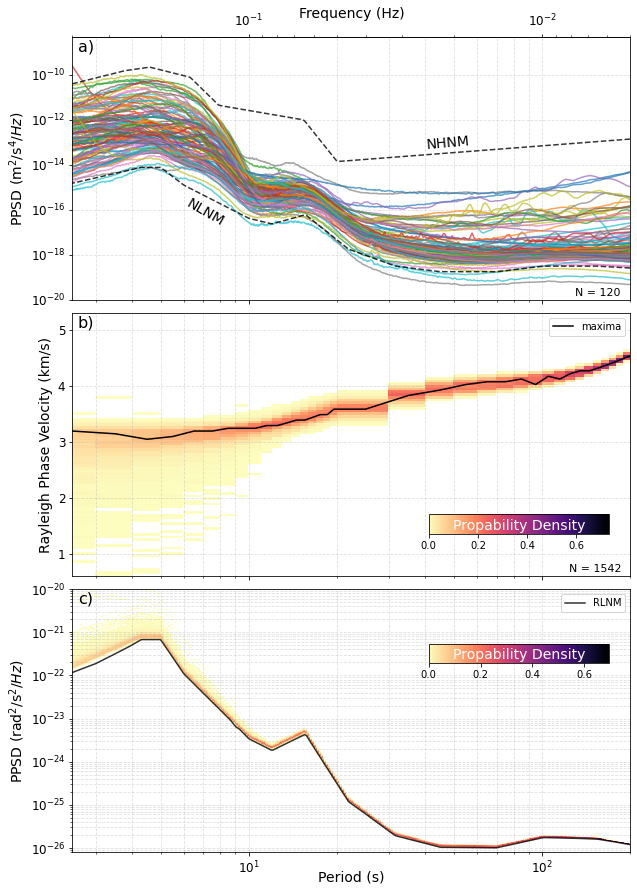

In [28]:
fig = __makeplot_colorlines_all(config,
                                sta_med_pp, sta_med, 
                                pp_land_rayleigh, vel_rayleigh_ppsd,
                                velocities_land_rayleigh,
                                rlnm_dist,
                               )

In [29]:
__savefig(fig, outpath=config['outpath_figures'], outname="joint_colorlines", mode="png", dpi=300)


   -> saving /import/kilauea-data/LNM/figures_final/joint_colorlines.png ...

   -> Done

